# One-Channel-ONN Project Console,Please run it in order!

In [0]:
import tensorflow as tf
import numpy as np
import sys
from tensorflow.python.client import device_lib
print('python-version:',sys.version,'tensorflow-version:',tf.__version__)
print(device_lib.list_local_devices())

python-version: 3.6.7 (default, Oct 22 2018, 11:32:17) 
[GCC 8.2.0] tensorflow-version: 1.13.1
[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15388843994990128802
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 11361863384255992026
physical_device_desc: "device: XLA_CPU device"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 5946715961754540931
physical_device_desc: "device: XLA_GPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14800692839
locality {
  bus_id: 1
  links {
  }
}
incarnation: 497524684182476226
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
]


## Load mnist data and Preprocess, Save them.

In [0]:
# load mnist database from tf.keras 
mnist = tf.keras.datasets.mnist
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# zero pad the image 28*28->100*100
x_train = np.pad(x_train,((0,),(36,),(36,)),'constant')
x_test = np.pad(x_test,((0,),(36,),(36,)),'constant')

# pixels value (0,255)->(0,1)
x_train = np.array(x_train/255.0,dtype='float32')
x_test = np.array(x_test/255.0,dtype='float32')

# labels dtype uint8 -> int32
y_train = np.array(y_train, dtype='int32')
y_test = np.array(y_test, dtype='int32')

# # separate training set into validation and new training set
# x_val, y_val = x_train[-5000:], y_train[-5000:]
# x_train, y_train = x_train[:55000], y_train[:55000]

# save it as .npy
np.save('x_train',x_train)
np.save('y_train',y_train)
# np.save('x_val',x_val)
# np.save('y_val',y_val)
np.save('x_test',x_test)
np.save('y_test',y_test)

print(x_train.shape, y_train.shape,x_test.shape, y_test.shape)

(60000, 100, 100) (60000,) (10000, 100, 100) (10000,)


## Take a look at some mnist data

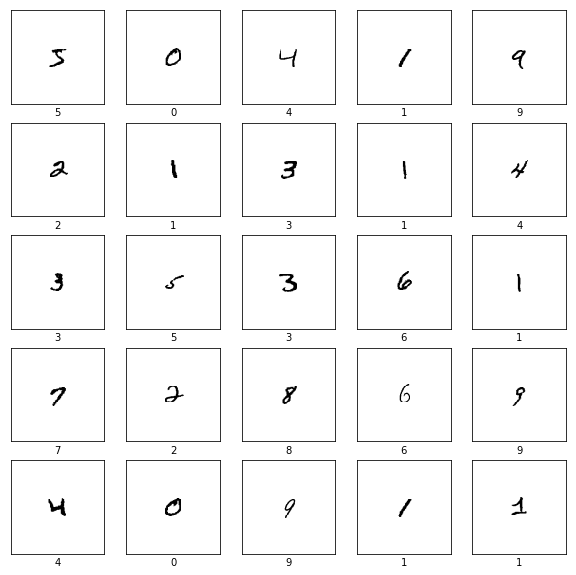

In [0]:
# take a look at some mnist data
#x_train = np.load('x_train.npy')
#y_train = np.load('y_train.npy')
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(10,10))

for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.axis('on')
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(y_train[i])
    # plt.title('image%d'%i) 
plt.show()

In [0]:
x_test = np.load('x_test.npy')
y_test = np.load('y_test.npy')


## Define Parameters

In [0]:
# Define parameters
period = 0.1E-3 # pixel size: 0.1mm
f = 5E-2 # focal length: 5cm
n = 100 # width_pixels # Number of pixels along one dimension (full image is nxn)
n_sub = (int) (n / 2)
A = n_sub * period 

# Define the spatial grid
xlist = np.linspace(0, n_sub, num=n_sub, endpoint=False) +  0.5 
front = -xlist[::-1]
xlist = np.hstack((front, xlist)) 
xlist_pos = xlist * period

xx = np.array(np.kron(xlist_pos, np.ones((n, 1))), dtype='float32')
yy = xx.T

# Define a constant wavelength tensor
Lambda = 0.75E-3 # Set the wavelength
Lambda = np.array(Lambda * np.ones((n,n)),dtype='float32')

# Define the reciprocal space cartesian grid   
k_x_pos = xlist / (n*period) # f_x
k_x = np.kron(k_x_pos, np.ones((n, 1)))
k_y = k_x.T

# Calculate the constant k_z tensor for subsequent propagator calculations
k_z = np.zeros((n, n)) + 0j
k = 2 * np.pi / Lambda
k_z[:, :] = np.sqrt(k ** 2 - k_x ** 2 - k_y ** 2 + 0j) # Add 0j to allow numpy to take square root of negative numbers
k_z = np.array(k_z, dtype='complex64')

In [0]:
print(xx.shape,xx.dtype, yy.shape,yy.dtype,Lambda.shape,Lambda.dtype, k_z.shape, k_z.dtype)

(100, 100) float32 (100, 100) float32 (100, 100) float32 (100, 100) complex64


In [0]:
np.save('xx', xx)
np.save('yy', yy)
np.save('Lambda', Lambda)
np.save('k_z', k_z)

## Detectors' position

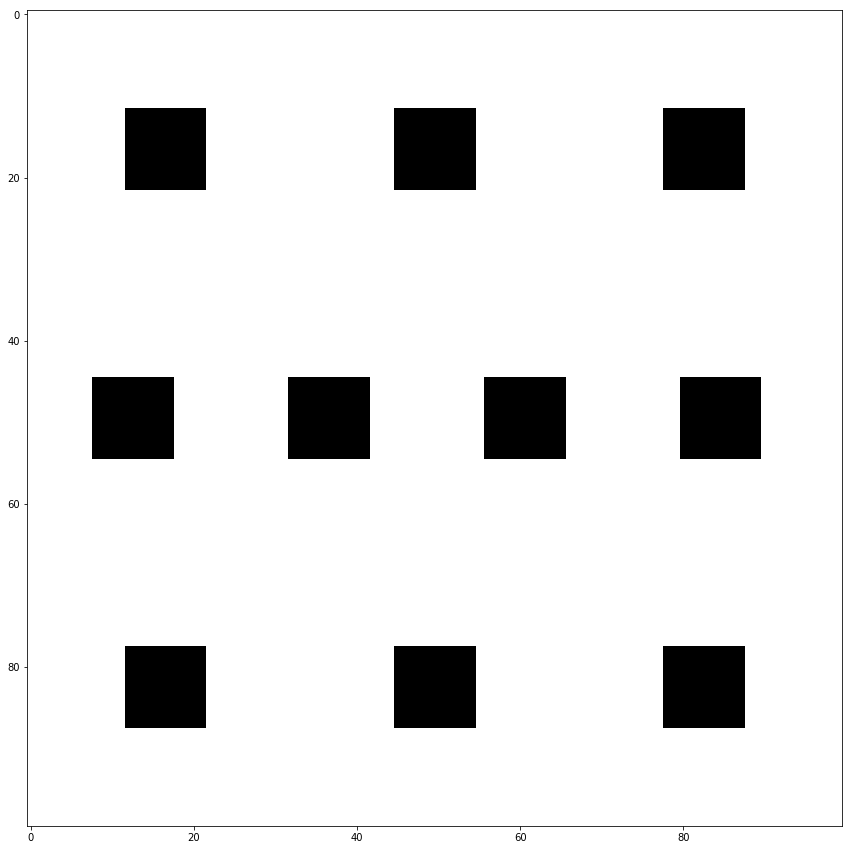

In [3]:
import numpy as np
inten=np.zeros((100,100))
inten[12:22, 12:22]=1 #0
inten[12:22, 45:55]=1 #1
inten[12:22, 78:88]=1 #2

inten[45:55, 8:18]=1  #3
inten[45:55, 32:42]=1 #4
inten[45:55, 56:66]=1 #5
inten[45:55, 80:90]=1 #6

inten[78:88, 12:22]=1 #7
inten[78:88, 45:55]=1 #8
inten[78:88, 78:88]=1 #9

import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(15,15))
plt.imshow(inten,cmap=plt.cm.binary)
plt.grid(False)
plt.show()

## 执行oc_onn_train

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
INFO:tensorflow:Summary name conv1/weights:0/gradient is illegal; using conv1/weights_0/gradient instead.
INFO:tensorflow:Summary name conv2/weights:0/gradient is illegal; using conv2/weights_0/gradient instead.
INFO:tensorflow:Summary name conv3/weights:0/gradient is illegal; using conv3/weights_0/gradient instead.
INFO:tensorflow:Summary name conv4/weights:0/gradient is illegal; using conv4/weights_0/gradient instead.
INFO:tensorflow:Summary name conv5/weights:0/gradient is illegal; using conv5/weights_0/gradient instead.
INFO:tensorflow:Summary name conv1/weights:0 is illegal; using conv1/weights_0 instead.
INFO:tensorflow:Summary name conv2/weights:0 is illegal; using conv2/weights_0 instead.
INFO:tensorflow:Summary name conv3/weights:0 is illegal; using conv3/weights_0 instead.
INFO:tensorflow:Summary name conv4/weights:0 is illegal; using conv4/weights_0 instead

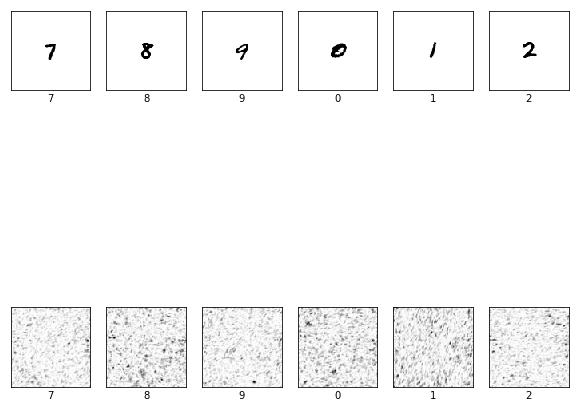

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

from oc_onn_train import *

### 显示训练后的权重

In [2]:
var_list

[<tf.Variable 'conv1/weights:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'conv2/weights:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'conv3/weights:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'conv4/weights:0' shape=(10, 10) dtype=float32_ref>,
 <tf.Variable 'conv5/weights:0' shape=(10, 10) dtype=float32_ref>]

In [5]:
import tensorflow as tf
with tf.Session() as sess:
  saver = tf.train.import_meta_graph('log/model_epoch10.ckpt.meta')
  saver.restore(sess, tf.train.latest_checkpoint('log/'))
  tvs = [v for v in tf.trainable_variables()]
  for v in tvs:
    print(v.name)
    print(sess.run(v))

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from log-test/model_epoch10.ckpt
conv1/weights:0
[[-0.10764449 -0.08810894 -0.17103684 -0.15954031 -0.07089886  0.06948239
  -0.05939099  0.04530602 -0.07171442  0.12706815]
 [-0.2111666   0.15617308 -0.06381638  0.02956211  0.20156598  0.18673776
   0.1777655   0.06159271  0.04797492  0.00629891]
 [ 0.02356562  0.17557639  0.03659873 -0.19337744  0.11224744  0.08427931
   0.00790014 -0.21921296 -0.05439214 -0.05460987]
 [-0.05804772  0.10714901 -0.03963915  0.00905833 -0.16496786  0.07398649
  -0.14480555  0.0901458  -0.15548024 -0.10572676]
 [ 0.04146345  0.05197476 -0.03750587 -0.19982865  0.01800513 -0.05116389
   0.23354544 -0.15004177  0.17721525 -0.2031283 ]
 [-0.05959774  0.19415322 -0.00104496  0.08672622 -0.046807    0.11576398
   0.01694319  0.10385437 -0.05460581  0.15364182]
 [ 0.14355895  0.09132361 -0.05516092 -0.17350812 -0.04161384 -0.09045707
  -